In [1]:
import pandas as pd
import numpy as np
import torch as tch
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout 
import matplotlib.pyplot as plt

In [3]:
col_names=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count", 
          "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","attack","difficulty_level"]
len(col_names)

43

<Axes: xlabel='attack'>

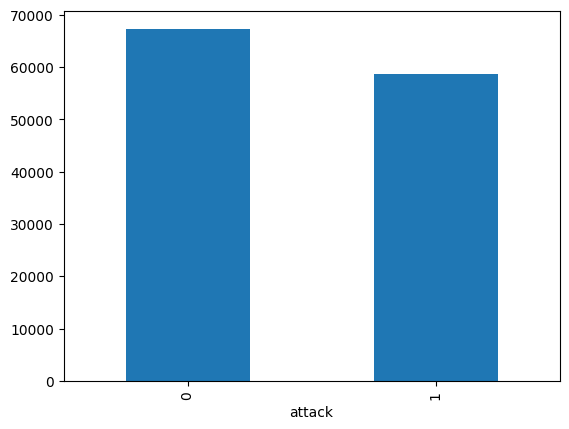

In [4]:
data=pd.read_csv("KDDTrain+.txt",header=None,names=col_names)
data.head()
data.loc[data['attack'] =="normal", 'attack'] = 0
data.loc[data['attack'] !=0, 'attack'] = 1
data['attack'].value_counts().plot.bar()

In [5]:
data = data.astype({'attack':'int'})
enc_Data=pd.get_dummies(data)
enc_Data.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,491,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
1,0,146,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False
3,0,232,8153,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
4,0,199,420,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False


In [7]:
X_train_real=enc_Data.drop(["attack"],axis=1)
Y_train_real=enc_Data["attack"]
from sklearn import preprocessing
x = X_train_real.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_df= pd.DataFrame(x_scaled)

In [15]:
X=normalized_df.to_numpy()
Y=Y_train_real.to_numpy()

In [16]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train, y_train= ros.fit_resample(X, Y)

In [17]:
print(X_train.shape,y_train.shape)
print(X.shape,Y.shape)

(134686, 123) (134686,)
(125973, 123) (125973,)


In [18]:
from collections import Counter
print(Counter(y_train))
print(Counter(Y))

Counter({0: 67343, 1: 67343})
Counter({0: 67343, 1: 58630})


In [19]:
datatest=pd.read_csv("KDDTest+.txt",header=None,names=col_names)
datatest.loc[datatest['attack'] =="normal", 'attack'] = 0
datatest.loc[datatest['attack'] !=0, 'attack'] = 1
datatest = datatest.astype({'attack':'int'})

enc_test=pd.get_dummies(datatest)
X_test=enc_Data.drop(["attack"],axis=1)
Y_test=enc_Data["attack"]
from sklearn import preprocessing
x = X_test.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_test_Scaled = min_max_scaler.fit_transform(x)
normalized_df_test= pd.DataFrame(x_test_Scaled)

X_te=normalized_df_test.to_numpy()

In [20]:
X_t = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_te = np.reshape(X_te, (X_te.shape[0], X_te.shape[1], 1))
#X_t[1].shape

#y_train.shape
y_test=Y_test.to_numpy()
#y_train.shape

In [29]:
model = Sequential() # initializing model
# input layer and first layer with 50 neurons
model.add(Conv1D(32, 3, padding="same",input_shape = (X_t.shape[1], 1), activation='relu'))
model.add(MaxPool1D(pool_size=(4)))  
model.add(Dropout(0.2))
model.add(Conv1D(32, 3, padding="same", activation='relu'))
model.add(MaxPool1D(pool_size=(4)))  
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=50))
# output layer with softmax activation
model.add(Dense(units=1,activation='softmax'))

In [30]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 123, 32)           128       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 30, 32)            0         
 g1D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 30, 32)            0         
                                                                 
 conv1d_5 (Conv1D)           (None, 30, 32)            3104      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 7, 32)             0         
 g1D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 7, 32)            

In [32]:
history = model.fit(X_t, y_train, epochs=100, batch_size=5000,validation_split=0.2)

Epoch 1/100
22/22 [==============================] - 17s 638ms/step - loss: 0.5263 - accuracy: 0.4658 - val_loss: 0.3683 - val_accuracy: 0.6368
Epoch 2/100
22/22 [==============================] - 13s 576ms/step - loss: 0.3090 - accuracy: 0.4658 - val_loss: 0.2412 - val_accuracy: 0.6368
Epoch 3/100
22/22 [==============================] - 12s 547ms/step - loss: 0.2247 - accuracy: 0.4658 - val_loss: 0.1896 - val_accuracy: 0.6368
Epoch 4/100
22/22 [==============================] - 12s 529ms/step - loss: 0.1815 - accuracy: 0.4658 - val_loss: 0.1598 - val_accuracy: 0.6368
Epoch 5/100
22/22 [==============================] - 11s 523ms/step - loss: 0.1552 - accuracy: 0.4658 - val_loss: 0.1354 - val_accuracy: 0.6368
Epoch 6/100
22/22 [==============================] - 12s 524ms/step - loss: 0.1356 - accuracy: 0.4658 - val_loss: 0.1177 - val_accuracy: 0.6368
Epoch 7/100
22/22 [==============================] - 11s 514ms/step - loss: 0.1241 - accuracy: 0.4658 - val_loss: 0.1093 - val_accuracy:

In [33]:
test_results = model.evaluate(X_te, y_test, verbose=1)

3937/3937 [==============================] - 10s 3ms/step - loss: 0.0159 - accuracy: 0.4654
